# 道路骨架提取

In [1]:
import geopandas as gpd
import momepy
import libpysal
from shapely.ops import voronoi_diagram
from shapely.ops import linemerge

# 准备建筑shp

761


C:\Users\Elena\AppData\Local\Temp\ipykernel_21008\1581527235.py:18: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  buildings.to_file(output_path, encoding='utf-8')
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'brand:en' to 'brand_en'
  ogr_write(
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'brand:wikidata' to 'brand_wiki'
  ogr_write(
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'brand:zh' to 'brand_zh'
  ogr_write(
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'name:en' to 'name_en'
  ogr_write(
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laund

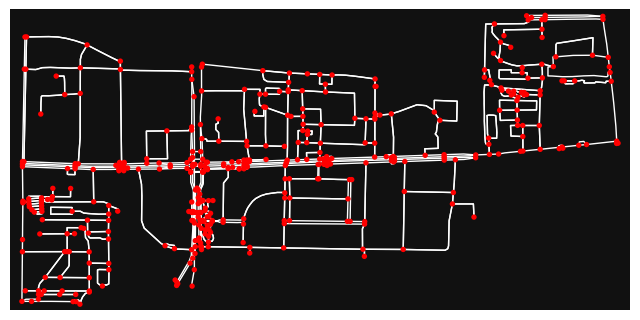

建筑物图层已保存为：buildings.shp


<Axes: >

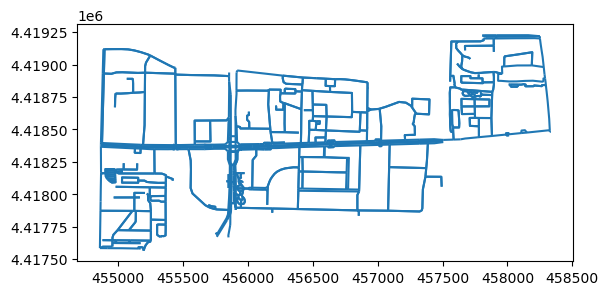

In [2]:
import osmnx as ox
import geopandas as gpd

# Step 1：设置区域名称
place_name = "	八里庄街道"

# Step 2：下载该区域的建筑图层
buildings = ox.features_from_place(place_name, tags={'building': True})

print(len(buildings))

# Step 3：保留 polygon 类型（建筑轮廓）
buildings = buildings[buildings.geometry.type.isin(['Polygon'])]
buildings=buildings.to_crs("EPSG:32650")
# Step 4：保存为 Shapefile（可在 QGIS 中查看）
output_path = "buildings.shp"

buildings.to_file(output_path, encoding='utf-8')
# 原图
G = ox.graph_from_place(place_name, network_type='all')
ox.plot_graph(G, node_color='red', edge_color='white')
print(f"建筑物图层已保存为：{output_path}")

# 创建节点
nodes,roads= ox.graph_to_gdfs(G, nodes=True, edges=True)
roads=roads.to_crs(buildings.crs)
roads.plot()

断头路节点数量： 6


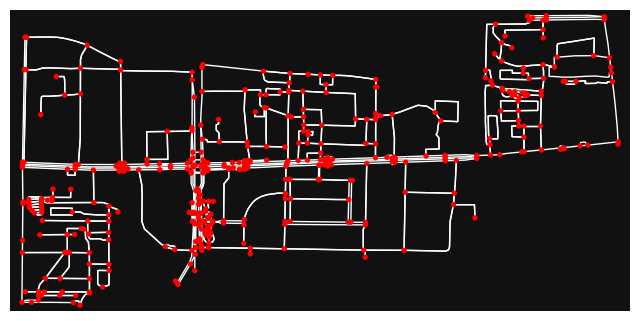

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [3]:
# 去掉断头路

dead_ends = [node for node, degree in G.degree() if degree < 2 ]
print("断头路节点数量：", len(dead_ends))

G_clean = G.copy()
for node in dead_ends:
    neighbors = list(G_clean.neighbors(node))
    if neighbors:
        G_clean.remove_edge(node, neighbors[0])  # 删除唯一一条边
    G_clean.remove_node(node)               # 删除该断头节点
ox.plot_graph(G_clean, node_color='red', edge_color='white')


D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\geopandas\array.py:1638: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 / UTM zone 50N (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))


22     126579.681129
25     130459.746967
28     436432.813712
39     132235.511139
40     175717.496023
41      20702.050538
42     837224.904049
43      65726.554679
44      95930.792258
51      55294.888004
52      19250.637468
62      14298.075626
65     171504.746610
78     126682.512785
81      77098.132101
93      28603.322082
94      31375.718066
101     74117.616585
102     15196.291055
104     52940.502006
105     30728.600514
106     45403.924371
107    251947.909901
108     25649.800853
110     25221.830901
113     71765.121504
114    173539.246187
119     45437.910157
122    115890.841437
129     76547.407278
144     35377.205848
151     39783.931382
153     43325.417693
154     16127.724598
155     35936.496482
167     57171.390383
168     19287.589764
169     41463.432789
170     10655.393848
171     90619.135534
173     38521.969235
177     14096.179784
178     14372.764214
179     68131.523752
192     31074.302482
194     48205.428124
202     44149.315072
203     19317

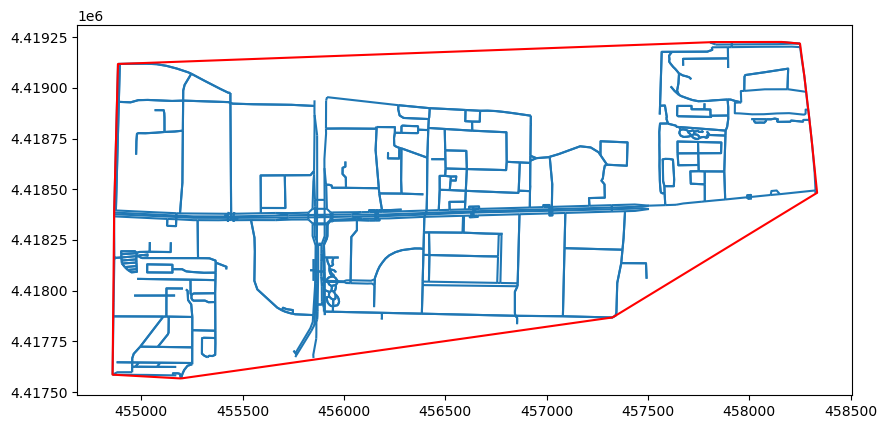

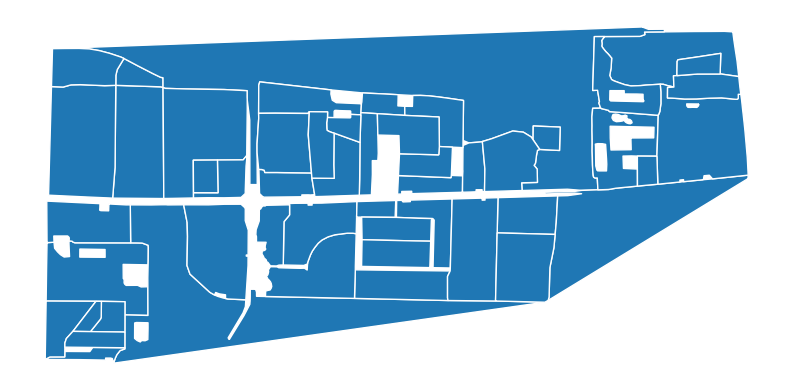

In [4]:
convex_hull = roads.union_all().convex_hull
enclosures = momepy.enclosures(roads, limit=convex_hull)
enclosures = enclosures[enclosures.area >10000]
ax = roads.plot(figsize=(10, 10))
gpd.GeoSeries([convex_hull.boundary]).plot(ax=ax, color="r")
# ax.set_axis_off()
enclosures.plot(figsize=(10, 10), edgecolor="w").set_axis_off()
print(enclosures.area)

760
EPSG:32650


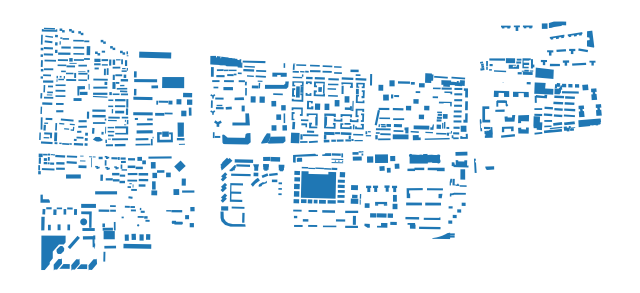

In [5]:
import momepy
import libpysal
from shapely.validation import make_valid
from shapely.geometry import Polygon, LineString
from shapely.errors import TopologicalError

# 建筑图层
buildings = gpd.read_file('buildings.shp')
print(len(buildings))
# 只保留 Polygon 或 MultiPolygon 类型

ax = buildings.plot(figsize=(8, 8))
ax.set_axis_off()
print(buildings.crs)


760
                                              geometry
0    POLYGON ((455029.25 4417729.762, 455030.485 44...
1    POLYGON ((454999.742 4417733.546, 454983.752 4...
2    POLYGON ((454962.232 4417877.124, 454931.351 4...
3    POLYGON ((455021.791 4417927.223, 455021.895 4...
4    POLYGON ((454967.817 4418031.286, 454967.742 4...
..                                                 ...
281  POLYGON ((458127.701 4419052.978, 458095.715 4...
282  POLYGON ((457811.467 4419110.516, 457801.836 4...
283  POLYGON ((457688.129 4419109.689, 457682.614 4...
284  POLYGON ((457821.288 4419103.936, 457815.792 4...
285  POLYGON ((457995.474 4419106.592, 457930.919 4...

[286 rows x 1 columns]


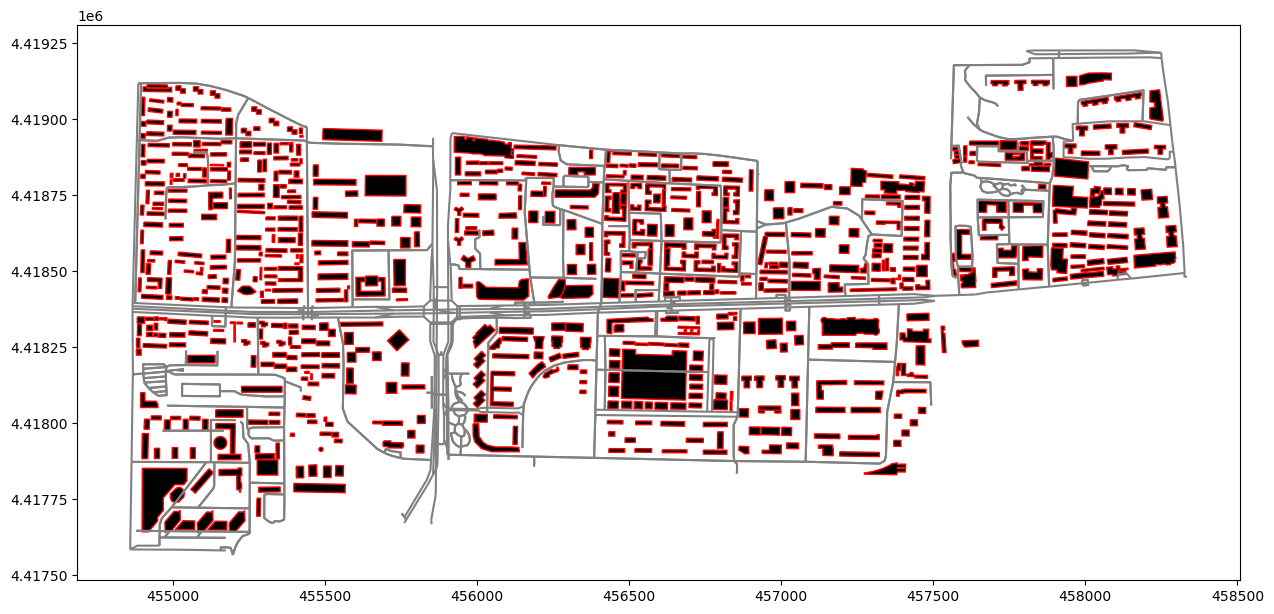

In [6]:
from shapely.ops import unary_union
from shapely.geometry import JOIN_STYLE,MultiPolygon, Polygon
import matplotlib.pyplot as plt

buildings_buffered_5m = buildings.copy()
buildings_buffered_5m["geometry"] = buildings_buffered_5m.geometry.buffer(5,join_style=JOIN_STYLE.mitre)
# 第二步：在原来基础上再扩 2 米，控制建筑之间的最小距离
buildings_buffered_7m = buildings_buffered_5m.copy()
buildings_buffered_7m["geometry"] = buildings_buffered_7m.geometry.buffer(2,join_style=JOIN_STYLE.mitre)
print(len(buildings))


# 第三步：将所有相交图形合并为单个 Polygon 或 MultiPolygon
merged_geometry = buildings_buffered_7m.geometry.union_all()
# 判断类型并拆分

# if isinstance(merged_geometry, MultiPolygon):
#     polygons = list(merged_geometry.geoms)
# elif isinstance(merged_geometry, Polygon):
#     polygons = [merged_geometry]


# 简化合并后的几何体
tolerance =10 # 可以根据需要调整精度

if isinstance(merged_geometry, MultiPolygon):
    polygons = [geom.simplify(tolerance=tolerance, preserve_topology=True) for geom in merged_geometry.geoms]
elif isinstance(merged_geometry, Polygon):
    polygons = [merged_geometry.simplify(tolerance=tolerance, preserve_topology=True)]

# if isinstance(merged_geometry, MultiPolygon):
#     polygons =  [geom.convex_hull for geom in merged_geometry.geoms]
# elif isinstance(merged_geometry, Polygon):
#     polygons = [merged_geometry.convex_hull]
else:
    raise ValueError("Unexpected geometry type")

# 创建新的 GeoDataFrame
split_gdf = gpd.GeoDataFrame(geometry=polygons, crs=buildings.crs)
fig, ax = plt.subplots(figsize=(15, 15))
buildings.plot(ax=ax, color="black",edgecolor="red")
# split_gdf.plot(ax=ax, color="black",edgecolor="red")
roads.plot(ax=ax, color="grey",)
print(split_gdf)

In [7]:
import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon, MultiPolygon, Point, LineString
from scipy.spatial import Delaunay

# 计算三角形外接圆心
def compute_circumcenter(p1, p2, p3):
    A = np.array(p1)
    B = np.array(p2)
    C = np.array(p3)

    mid_ab = (A + B) / 2
    dir_ab = B - A
    perp_ab = np.array([-dir_ab[1], dir_ab[0]])

    mid_bc = (B + C) / 2
    dir_bc = C - B
    perp_bc = np.array([-dir_bc[1], dir_bc[0]])

    try:
        t = np.linalg.solve(np.column_stack((perp_ab, -perp_bc)), mid_bc - mid_ab)
        center = mid_ab + t[0] * perp_ab
        return center
    except np.linalg.LinAlgError:
        return None

# 主函数：输入 enclosure 和 buildings，输出骨架线
def extract_skeleton_from_enclosure(buildings_in, enclosure_geom, spacing):
    # 合并建筑为一个几何体
    buildings_union = buildings_in.unary_union
    blank_area = enclosure_geom.difference(buildings_union)
    # print("buildings:",buildings.type)
    # print("buildings_union:",buildings_union.type)
    # print("enclosure_geom:",enclosure_geom.type)
    # print("blank_area:",blank_area.type)
    # ax =blank_area.plot(figsize=(8, 8))
    # ax.set_axis_off()
    # 统一为列表格式
    if isinstance(blank_area, Polygon):
        blank_area = [blank_area]
    elif isinstance(blank_area, MultiPolygon):
        # blank_area = list(blank_area)
        blank_area = list(blank_area.geoms)

    # Step 1：采样空白区域边界上的点（包括 exterior 和 holes）
    coords = []

    for poly in blank_area:
        if isinstance(poly, MultiPolygon):
            polys = list(poly.geoms)  # 拆成单个 Polygon
        else:
            polys = [poly]

        for single_poly in polys:
            # 外边界
            ext_length =single_poly.exterior.length
            ext_n = int(ext_length // spacing)
            for i in range(ext_n):
                pt = single_poly.exterior.interpolate(i * spacing)
                coords.append([pt.x, pt.y])
            # 内部孔洞
            for interior in single_poly.interiors:
                int_length = interior.length
                int_n = int(int_length // spacing)
                for i in range(int_n):
                    pt = interior.interpolate(i * spacing)
                    coords.append([pt.x, pt.y])

    if len(coords) < 3:
        return gpd.GeoDataFrame(geometry=[], crs=buildings_in.crs)

    # Step 2：构建 Delaunay 三角网
    points = np.array(coords)
    tri = Delaunay(points)

    # Step 3：计算每个三角形的外接圆心
    centers = []
    for simplex in tri.simplices:
        p1, p2, p3 = points[simplex[0]], points[simplex[1]], points[simplex[2]]
        center = compute_circumcenter(p1, p2, p3)
        centers.append(center if center is not None else None)

    # Step 4：连接相邻三角形的圆心 → 构建骨架线
    lines = []
    for i, neighbors in enumerate(tri.neighbors):
        c1 = centers[i]
        if c1 is None:
            continue
        for j, neighbor in enumerate(neighbors):
            if neighbor != -1 and i < neighbor:  # 防止重复
                c2 = centers[neighbor]
                if c2 is not None:
                    line = LineString([c1, c2])
                    # 检查线段是否在空白区域内部
                    mid = line.interpolate(0.5, normalized=True)
                    if any(poly.contains(Point(mid)) for poly in blank_area):
                        lines.append(line)

    # Step 5：转为 GeoDataFrame 输出
    return gpd.GeoDataFrame(geometry=lines, crs=buildings_in.crs)


In [8]:
import networkx as nx
from shapely.geometry import LineString, Point
def clean_skeleton_network(skeleton_gdf, min_length):
    """
    输入为初步骨架线 GeoDataFrame，输出为简化的、干净的“道路骨架网络”
    """
    import networkx as nx
    from shapely.geometry import LineString, MultiLineString

    G = nx.Graph()

    for geom in skeleton_gdf.geometry:
        # 兼容 MultiLineString
        if isinstance(geom, LineString):
            lines = [geom]
        elif isinstance(geom, MultiLineString):
            lines = list(geom.geoms)
        else:
            continue

        for line in lines:
            if line.length < min_length:
                continue
            coords = list(line.coords)
            for i in range(len(coords) - 1):
                p1 = tuple(np.round(coords[i], 3))
                p2 = tuple(np.round(coords[i+1], 3))
                G.add_edge(p1, p2, geometry=LineString([p1, p2]))

    # 保留所有有效子图（至少有2条边）
    cleaned_lines = []
    for component in nx.connected_components(G):
        subG = G.subgraph(component).copy()
        if subG.number_of_edges() < 2:
            continue  # 忽略孤立路径

        # 清理挂链节点
        dangling = [n for n in subG.nodes if subG.degree[n] == 1]
        subG.remove_nodes_from(dangling)

        for u, v, data in subG.edges(data=True):
            cleaned_lines.append(data["geometry"])

    return gpd.GeoDataFrame(geometry=cleaned_lines, crs=skeleton_gdf.crs)

In [9]:
import networkx as nx
from shapely.geometry import LineString
import numpy as np
from shapely.ops import linemerge

def angle_between(p1, p2, p3):
    """计算 ∠p2 的夹角（度数）"""
    a = np.array(p1)
    b = np.array(p2)
    c = np.array(p3)
    v1 = a - b
    v2 = c - b
    cos_theta = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    return np.degrees(np.arccos(cos_theta))

# def merge_zigzag_segments(skeleton_gdf, angle_threshold):
#     """
#     将由短线段组成的 zigzag 骨架线合并成方向稳定的长直线
#     """
#     edge_geom_map = {}  # 记录每条边对应的原始线段
#     G = nx.Graph()
#     for line in skeleton_gdf.geometry:
#         coords = list(line.coords)
#         for i in range(len(coords) - 1):
#             p1 = tuple(np.round(coords[i], 3))
#             p2 = tuple(np.round(coords[i+1], 3))
#             G.add_edge(p1, p2)
#             edge_geom_map[frozenset([p1, p2])] = LineString([p1, p2])
#
#     merged_lines = []
#     used_edges = set()
#
#     for component in nx.connected_components(G):
#         subG = G.subgraph(component)
#         deg = dict(subG.degree())
#         endpoints = [n for n in subG.nodes if deg[n] == 1]
#
#         if len(endpoints) < 2:
#             continue
#
#         try:
#             path = nx.shortest_path(subG, source=endpoints[0], target=endpoints[1])
#         except:
#             continue
#
#         # 分段拟合：当角度变化过大就断开
#         segment = [path[0], path[1]]
#         for i in range(2, len(path)):
#             angle = angle_between(path[i - 2], path[i - 1], path[i])
#             if angle < (180 - angle_threshold):
#                 if len(segment) >= 2:
#                     merged_lines.append(LineString([segment[0], segment[-1]]))
#                     for j in range(len(segment) - 1):
#                         used_edges.add(frozenset([segment[j], segment[j + 1]]))
#                 segment = [path[i - 1], path[i]]
#             else:
#                 segment.append(path[i])
#
#         if len(segment) >= 2:
#             merged_lines.append(LineString([segment[0], segment[-1]]))
#             for j in range(len(segment) - 1):
#                 used_edges.add(frozenset([segment[j], segment[j + 1]]))
#
#     # 补回未被处理的原始线段
#     remaining_edges = [
#         geom for edge, geom in edge_geom_map.items()
#         if edge not in used_edges
#     ]
#     merged_lines.extend(remaining_edges)
#
#     return gpd.GeoDataFrame(geometry=merged_lines, crs=skeleton_gdf.crs)

def merge_zigzag_segments(skeleton_gdf, epsilon):
    """
    替代 merge_zigzag_segments：先合并骨架为整体线形，再简化曲折线段。

    参数:
        skeleton_gdf: GeoDataFrame，输入骨架线段
        epsilon: 简化公差（越大线越直）

    返回:
        simplified_gdf: GeoDataFrame，合并并简化后的骨架线段
    """
    # 合并线段为一条或多条连续线
    merged_line = linemerge(MultiLineString(skeleton_gdf.geometry.values))

    # 构造 GeoSeries
    merged_series = gpd.GeoSeries([merged_line], crs=skeleton_gdf.crs)

    # 简化几何
    simplified_geom = merged_series.apply(lambda geom: geom.simplify(epsilon, preserve_topology=False))

    # 转为 GeoDataFrame 返回
    simplified_gdf = gpd.GeoDataFrame(geometry=simplified_geom, crs=skeleton_gdf.crs)

    return simplified_gdf

C:\Users\Elena\AppData\Local\Temp\ipykernel_21008\117965559.py:30: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buildings_union = buildings_in.unary_union
C:\Users\Elena\AppData\Local\Temp\ipykernel_21008\117965559.py:30: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buildings_union = buildings_in.unary_union
C:\Users\Elena\AppData\Local\Temp\ipykernel_21008\117965559.py:30: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buildings_union = buildings_in.unary_union
C:\Users\Elena\AppData\Local\Temp\ipykernel_21008\117965559.py:30: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buildings_union = buildings_in.unary_union
C:\Users\Elena\AppData\Local\Temp\ipykernel_21008\117965559.py:30: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all

<Axes: >

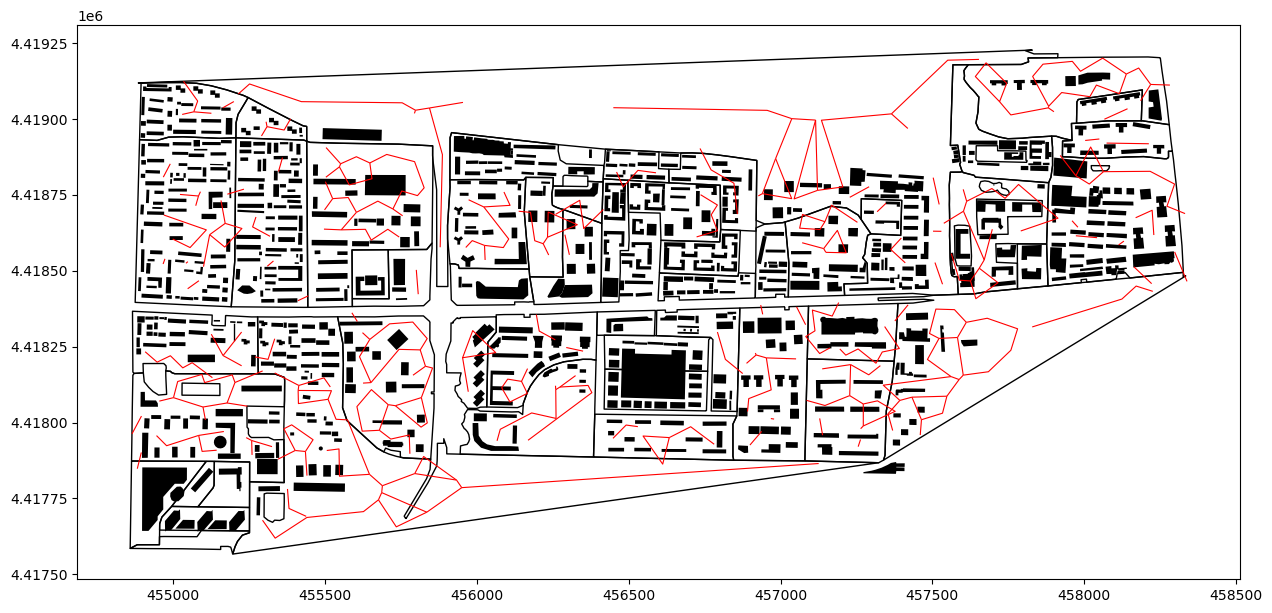

In [10]:
import geopandas as gpd
import pandas as pd
import shapely
from shapely.geometry import Point, Polygon, MultiPolygon,MultiLineString
from scipy.spatial import Voronoi
import numpy as np
import matplotlib as plt

# 确保是投影坐标系（如 UTM）
buildings = buildings.to_crs(epsg=32650)
enclosures = enclosures.to_crs(epsg=32650)

# 结果列表
all_skeletons_raw = []
all_skeletons_clean = []
all_skeletons= []

# 遍历每个 enclosure
for idx, row in enclosures.iterrows():
    enclosure_geom = row["geometry"]
    # inside = buildings[buildings.geometry.centroid.intersects(enclosure_geom)]
    inside = split_gdf[split_gdf.geometry.centroid.intersects(enclosure_geom)]

    if len(inside) < 2:
        continue

    skel_raw = extract_skeleton_from_enclosure(inside, enclosure_geom,100)
    skel_clean = clean_skeleton_network(skel_raw,5)
    skel_straight = merge_zigzag_segments(skel_clean,20)

    all_skeletons_raw.append(skel_raw)
    all_skeletons_clean.append(skel_clean)
    all_skeletons.append(skel_straight)

# 合并为 GeoDataFrame
skeleton_raw = gpd.GeoDataFrame(pd.concat( all_skeletons_raw, ignore_index=True), crs=buildings.crs)
skeleton_clean= gpd.GeoDataFrame(pd.concat( all_skeletons_clean, ignore_index=True), crs=buildings.crs)
skeleton_total = gpd.GeoDataFrame(pd.concat(all_skeletons, ignore_index=True), crs=buildings.crs)

ax = enclosures.plot(edgecolor="black", facecolor="none", figsize=(15, 15))
buildings.plot(ax=ax, color="black")
# split_gdf.plot(ax=ax, color="black",alpha=0.3)
# skeleton_raw .plot(ax=ax, color="grey", linewidth=0.8)
# skeleton_clean.plot(ax=ax, color="blue", linewidth=0.8)
skeleton_total.plot(ax=ax, color="red", linewidth=0.8)
# for idx, row in enclosures.iterrows():
#     eID = row["eID"]
#     enclosure_geom = row["geometry"]
#
#     inside = buildings[buildings.geometry.centroid.intersects(enclosure_geom)]
#     print(f"eID {eID} 有 {len(inside)} 个建筑")
#
#     # 可视化这个 enclosure 和其中的建筑
#     ax = gpd.GeoSeries([enclosure_geom]).plot(facecolor='none', edgecolor='red')
#     inside.plot(ax=ax, color='blue')



<Axes: >

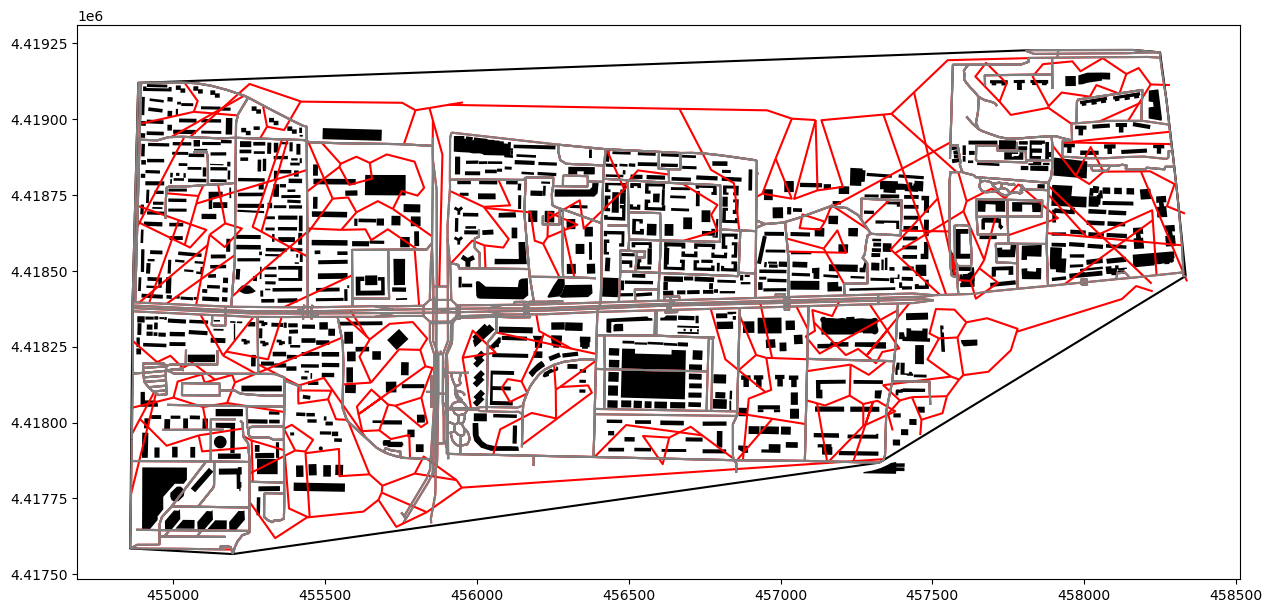

In [11]:
# 假设你已有两个 GeoDataFrame:
# roads: 原有道路线网
# skeleton_total: 所有街区合并后的骨架线（经过 clean + straighten）
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import LineString, MultiLineString

# 将 roads 转为 skeleton_total 的投影坐标
polygon = Polygon(convex_hull.boundary)
hull=gpd.GeoDataFrame(geometry=[polygon],crs="EPSG:32650")
hull = hull.to_crs(epsg=32650)
enclosures_proj = enclosures.to_crs(skeleton_total.crs)
roads_proj = roads.to_crs(skeleton_total.crs)

# 合并后设置为统一的投影 CRS
all_roads = gpd.GeoDataFrame(
    pd.concat([roads_proj, skeleton_total], ignore_index=True),
    crs=skeleton_total.crs  # ✅ 用统一的投影坐标系
)
# closed = momepy.close_gaps(all_roads ,10)
closed = momepy.extend_lines(all_roads , tolerance=800)
# 可视化
fig, ax = plt.subplots(figsize=(15, 15))
# ax = all_roads.plot(edgecolor="black", facecolor="none", figsize=(20, 20))
closed.plot(ax=ax, color="red")
hull =gpd.GeoDataFrame(geometry=[convex_hull.boundary],crs="EPSG:32650")
hull.plot(ax=ax, color="black")
buildings.plot(ax=ax, color="black")
roads_proj.plot(ax=ax, color="grey")

In [12]:
from shapely.geometry import LineString
from shapely.ops import transform
import geopandas as gpd
from shapely.ops import linemerge
from shapely.geometry import MultiLineString


print(skeleton_total.type)
skeleton_total_line = linemerge(MultiLineString(skeleton_total.geometry.values))
# 构建 GeoSeries 用于绘图
original_geom = gpd.GeoSeries([skeleton_total_line], crs="EPSG:32560")

# 构建 GeoDataFrame 用于简化处理
simplified_roads = gpd.GeoDataFrame(geometry=original_geom.copy())

# 线简化
epsilon = 100
simplified_roads['geometry'] = simplified_roads['geometry'].apply(
    lambda geom: geom.simplify(epsilon, preserve_topology=False)
)
# 可视化
# ax = all_roads.plot(edgecolor="black", facecolor="none", figsize=(20, 20))

# 绘图对比
ax = original_geom.plot(color='gray', linewidth=1,alpha = 0.2, figsize=(15, 15))
# closed.plot(ax=ax, color="red")
buildings.plot(ax=ax, color="black")
roads_proj.plot(ax=ax, color="grey")
simplified_roads.plot(ax=ax, color='red', linewidth=1)

0        MultiLineString
1        MultiLineString
2        MultiLineString
3        MultiLineString
4        MultiLineString
5        MultiLineString
6        MultiLineString
7        MultiLineString
8        MultiLineString
9     GeometryCollection
10            LineString
11       MultiLineString
12       MultiLineString
13       MultiLineString
14            LineString
15       MultiLineString
16       MultiLineString
17            LineString
18       MultiLineString
19       MultiLineString
20       MultiLineString
21            LineString
22       MultiLineString
23       MultiLineString
24       MultiLineString
25       MultiLineString
26            LineString
27            LineString
28       MultiLineString
29       MultiLineString
30       MultiLineString
31    GeometryCollection
32            LineString
33       MultiLineString
34            LineString
35            LineString
dtype: object


TypeError: 'MultiLineString' object is not iterable

In [ ]:
# 合并后设置为统一的投影 CRS
all_roads = gpd.GeoDataFrame(
    pd.concat([roads_proj, simplified_roads.geometry], ignore_index=True) # ✅ 用统一的投影坐标系
)
# closed = momepy.close_gaps(all_roads ,10)
closed = momepy.extend_lines(all_roads , tolerance=200)
# 可视化
ax = all_roads.plot(edgecolor="black", facecolor="none", figsize=(20, 20))
# closed.plot(ax=ax, color="red")
buildings.plot(ax=ax, color="black")
# roads_proj.plot(ax=ax, color="grey")

In [ ]:
import geopandas as gpd
import pandas as pd
import shapely
from shapely.geometry import Point,LineString, Polygon, MultiPolygon
from scipy.spatial import Voronoi
import numpy as np
import matplotlib.pyplot as plt



# # 确保是投影坐标系（如 UTM）
# buildings = buildings.to_crs(epsg=32650)
# print(convex_hull.boundary)
polygon = Polygon(convex_hull.boundary)

hull=gpd.GeoDataFrame(geometry=[polygon],crs="EPSG:32650")
hull = hull.to_crs(epsg=32650)
# ax = hull.plot(edgecolor="black", facecolor="none", figsize=(15, 15))
print("hull:", hull.type)
# print("buildings:", buildings.total_bounds)

# 结果列表
all_skeletons_raw = []
all_skeletons_clean = []
all_skeletons= []

# # 遍历每个 enclosure
# for idx, row in enclosures.iterrows():
#     enclosure_geom = row["geometry"]
#     # print(buildings)
#     skel_raw = extract_skeleton_from_enclosure(buildings, enclosure_geom,100)
#     skel_clean = clean_skeleton_network(skel_raw,5)
#     skel_straight = merge_zigzag_segments(skel_clean,15)
#
#     all_skeletons_raw.append(skel_raw)
#
#     all_skeletons_clean.append(skel_clean)
#     all_skeletons.append(skel_straight)
# 遍历每个 enclosure


# print(buildings)
skel_raw = extract_skeleton_from_enclosure(buildings,hull,100)
skel_clean = clean_skeleton_network(skel_raw,10)
skel_straight = merge_zigzag_segments(skel_clean,50)

# all_skeletons_raw.append(skel_raw)
#
# all_skeletons_clean.append(skel_clean)
# all_skeletons.append(skel_straight)

# # 合并为 GeoDataFrame
# skeleton_raw = gpd.GeoDataFrame(skel_raw , crs=buildings.crs)
# skeleton_clean= gpd.GeoDataFrame(pd.concat( all_skeletons_clean, ignore_index=True), crs=buildings.crs)
# skeleton_total = gpd.GeoDataFrame(pd.concat(all_skeletons, ignore_index=True), crs=buildings.crs)

fig, ax = plt.subplots(figsize=(15, 15))


# 将 roads 转为 skeleton_total 的投影坐标
buildings = buildings.to_crs(hull.crs)
hull.plot(ax=ax,edgecolor="black")
buildings.plot(ax=ax, color="black",edgecolor="white")
# skel_raw .plot(ax=ax, color="red", linewidth=0.8)
# skel_clean.plot(ax=ax, color="green", linewidth=0.8)
skel_straight.plot(ax=ax, color="blue", linewidth=0.8)
plt.show()



<Axes: >

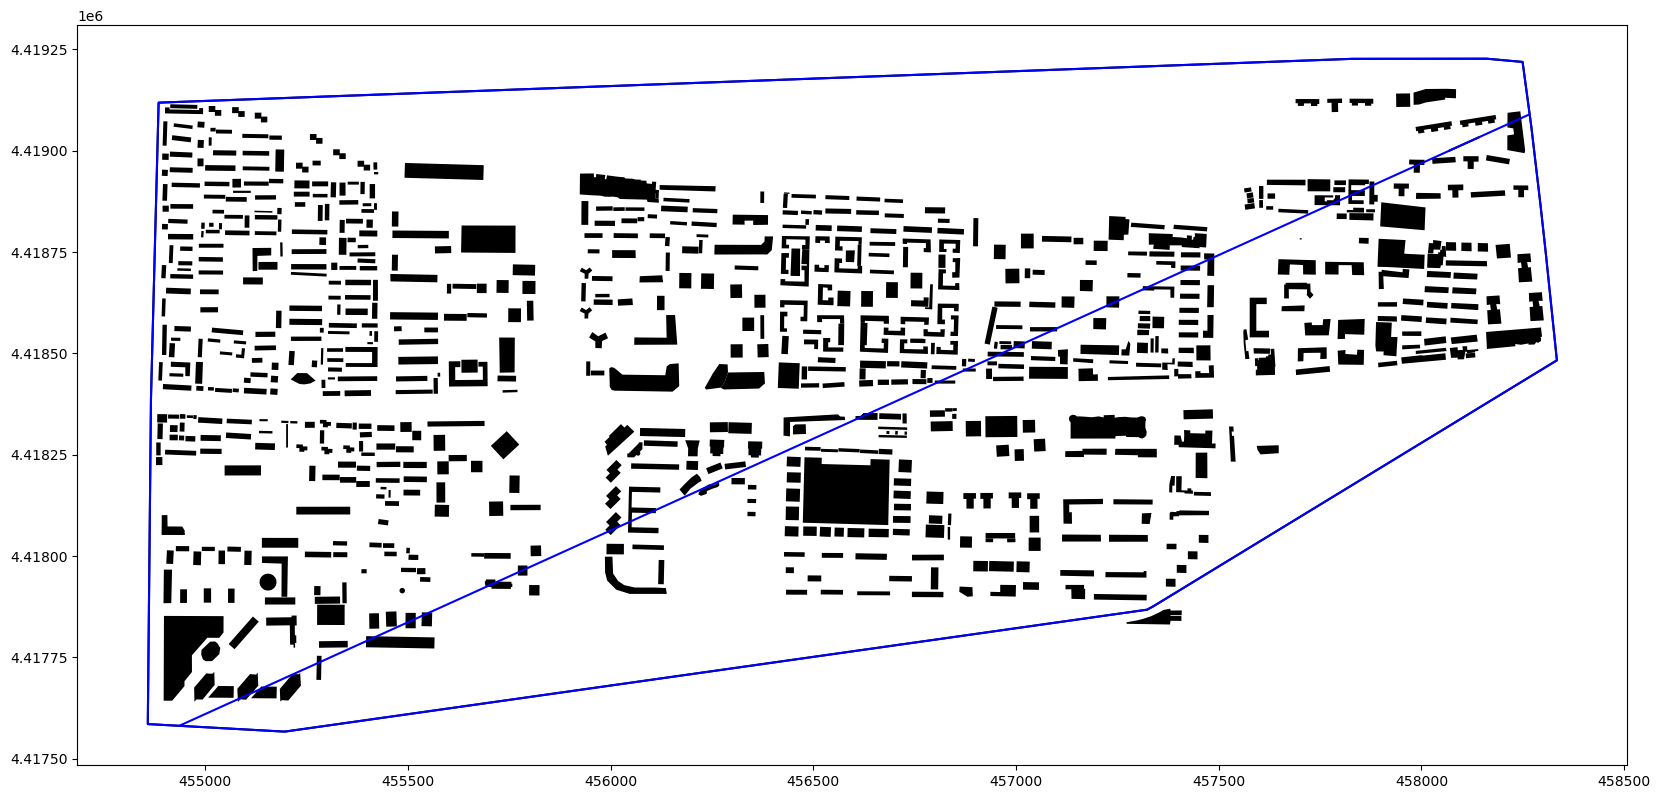

In [13]:
# 假设你已有两个 GeoDataFrame:
# roads: 原有道路线网
# skeleton_total: 所有街区合并后的骨架线（经过 clean + straighten）

import geopandas as gpd
from shapely.geometry import LineString, MultiLineString


hull_proj = hull.to_crs(skel_straight.crs)

# 合并后设置为统一的投影 CRS
all_roads = gpd.GeoDataFrame(
    pd.concat([hull_proj, skel_straight], ignore_index=True),
    crs=skel_straight.crs  # ✅ 用统一的投影坐标系
)
# closed = momepy.close_gaps(all_roads ,10)
closed = momepy.extend_lines(all_roads , tolerance=8000)
# 可视化
ax = all_roads.plot(edgecolor="black", facecolor="none", figsize=(20, 20))
closed.plot(ax=ax, color="blue")
buildings.plot(ax=ax, color="black")
# roads_proj.plot(ax=ax, color="grey")

In [2]:
import os

# 所有要创建的相对路径
folders = [
    "data/raw/road_network_osm",
    "data/raw/building_footprints",
    "data/raw/poi_raw",
    "data/preprocessed/road_network_cache",
    "data/preprocessed/building_groups",
    "data/preprocessed/node_edge_graphs",
    "data/preprocessed/node_features",
    "data/preprocessed/edge_features",
    "data/preprocessed/labels",
    "data/processed_stats",

    "notebooks",

    "utils",

    "models",

    "output_visualization/edge_attribute_plots",
    "output_visualization/node_attribute_plots"
]

# 在当前目录创建所有文件夹
for folder in folders:
    os.makedirs(folder, exist_ok=True)

print("✅ 项目结构创建完成！")

✅ 项目结构创建完成！
